<a href="https://colab.research.google.com/github/Fridayy12/Feature_Detection_Algorithms/blob/main/py_ntbk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup and Imports

In [1]:
# Install required packages
!pip install opencv-python opencv-contrib-python matplotlib numpy

# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files

# Download sample images
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box.png -O box.png
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box_in_scene.png -O box_in_scene.png
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/blox.jpg -O blox.jpg

--2025-04-08 17:00:32--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50728 (50K) [image/png]
Saving to: ‘box.png’

box.png             100%[===================>]  49.54K  --.-KB/s    in 0.01s   

2025-04-08 17:00:32 (4.01 MB/s) - ‘box.png’ saved [50728/50728]

--2025-04-08 17:00:33--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box_in_scene.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122490 (120K) [image/png]
Saving to: 

SIFT Feature Matching Implementation

SIFT Feature Matching Results:


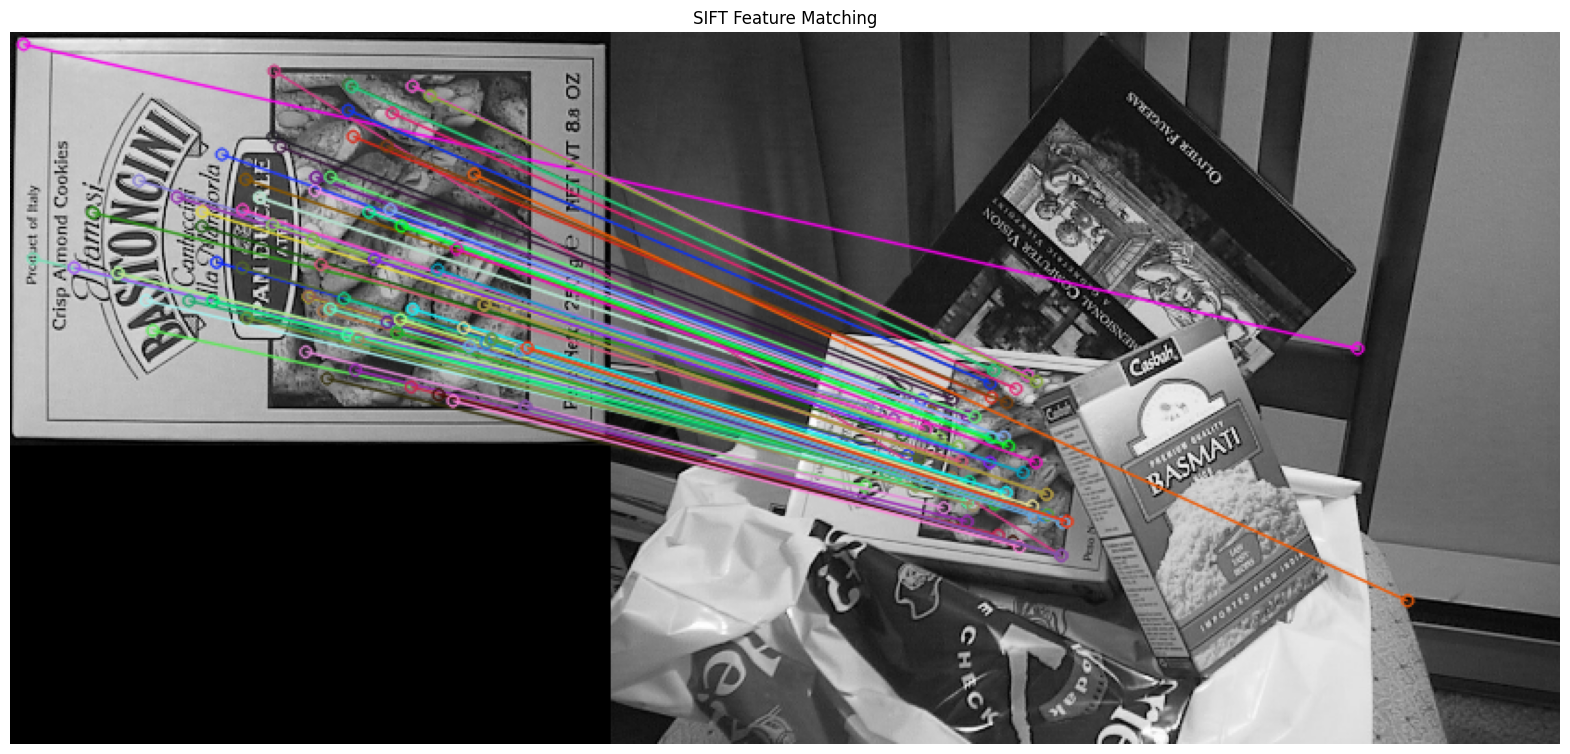

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
def sift_feature_matching(img1_path, img2_path):
    # Read images
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    # Draw matches
    img_matches = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=2)

    # Display results
    plt.figure(figsize=(20,10))
    plt.imshow(img_matches)
    plt.axis('off')
    plt.title('SIFT Feature Matching')
    plt.show()

    # Save output
    cv2.imwrite('sift_matches.jpg', img_matches)
    files.download('sift_matches.jpg')

# Execute SIFT
print("SIFT Feature Matching Results:")
sift_feature_matching('box.png', 'box_in_scene.png')

Harris Corner Detection Implementation


Harris Corner Detection Results:


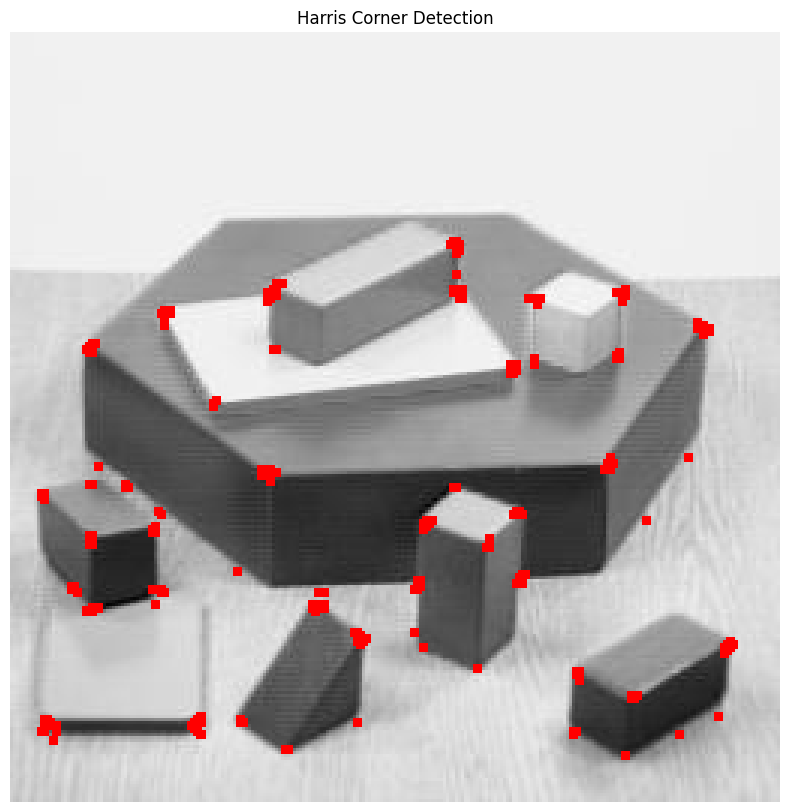

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
def harris_corner_detection(img_path):
    # Read image
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Harris corner detection
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

    # Dilate to mark the corners
    dst = cv2.dilate(dst, None)

    # Threshold for optimal value
    img[dst > 0.01 * dst.max()] = [0, 0, 255]

    # Display results
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Harris Corner Detection')
    plt.show()

    # Save output
    cv2.imwrite('harris_corners.jpg', img)
    files.download('harris_corners.jpg')

# Execute Harris Corner Detection
print("\nHarris Corner Detection Results:")
harris_corner_detection('blox.jpg')

RANSAC for Outlier Removal Implementation


RANSAC Feature Matching Results:


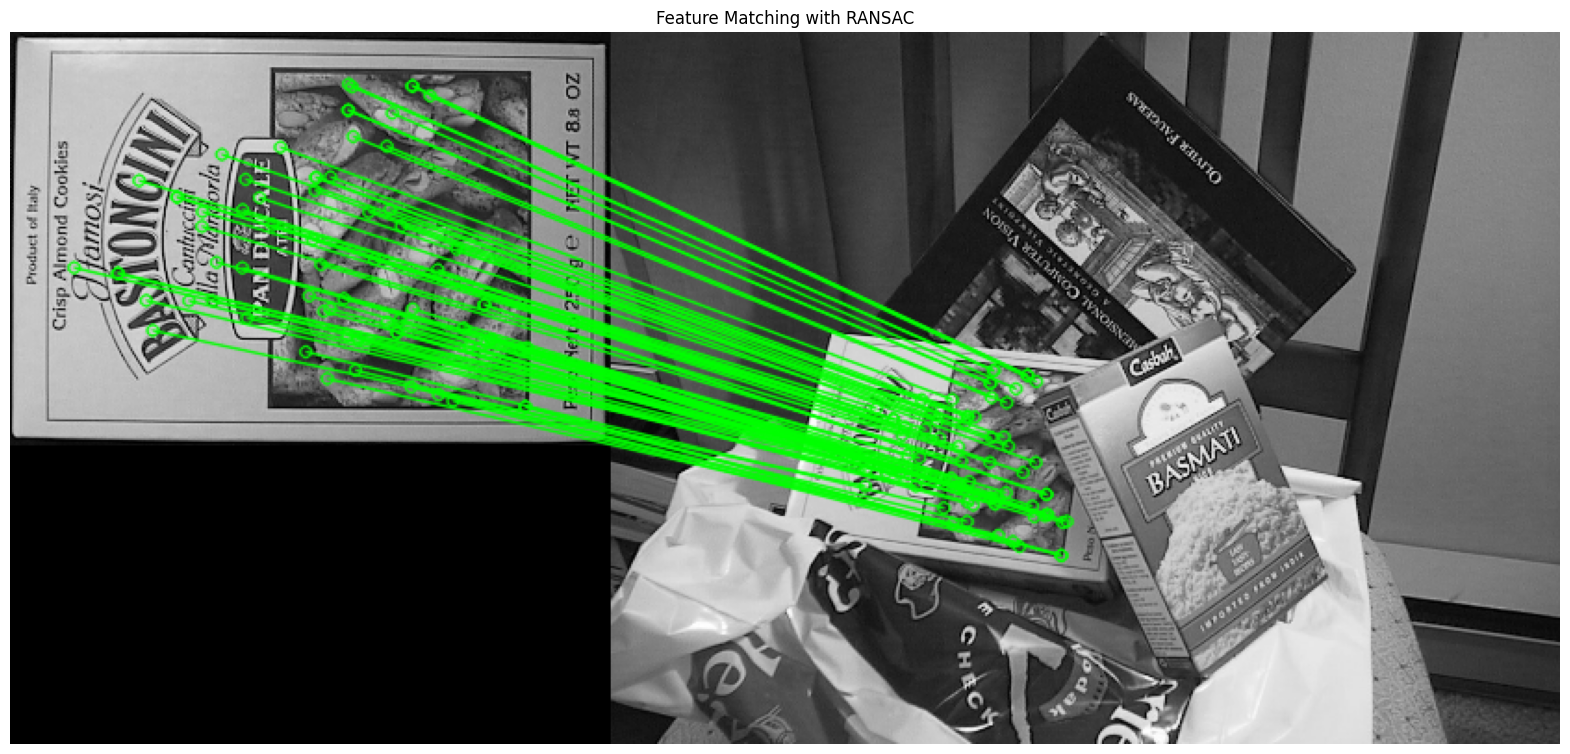

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
def ransac_feature_matching(img1_path, img2_path):
    # Read images
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    # Extract location of good matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Find homography using RANSAC
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Draw matches with RANSAC inliers
    draw_params = dict(matchColor=(0,255,0), # green for inliers
                      singlePointColor=None,
                      matchesMask=matchesMask,
                      flags=2)
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

    # Display results
    plt.figure(figsize=(20,10))
    plt.imshow(img_matches)
    plt.axis('off')
    plt.title('Feature Matching with RANSAC')
    plt.show()

    # Save output
    cv2.imwrite('ransac_matches.jpg', img_matches)
    files.download('ransac_matches.jpg')

# Execute RANSAC
print("\nRANSAC Feature Matching Results:")
ransac_feature_matching('box.png', 'box_in_scene.png')